# Training Model

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("deep")
sns.set_style('darkgrid')

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

from model.densenet_model import DenseNetModel
from datasets.hams_dataset import HamDataset

## Dataset & Dataloader

In [2]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

In [3]:
attr = 'dark_corner'
label = 'nv'

biased_train_dataset = HamDataset('train_biased.csv', attr, label, transform = preprocess)
unbiased_train_dataset = HamDataset('train_unbiased.csv', attr, label, transform = preprocess)
val_dataset = HamDataset('val.csv', attr, label, transform = preprocess)
test_dataset = HamDataset('test.csv', attr, label, transform = preprocess)

In [4]:
batch_size = 16

train_biased_dataloader = DataLoader(biased_train_dataset, batch_size=batch_size, shuffle=True)
train_unbiased_dataloader = DataLoader(unbiased_train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Training Loop

In [5]:
PATH = 'model/saved_model/densenet/'

In [6]:
if not os.path.exists(PATH) : os.makedirs(PATH)

In [7]:
def train_step(model, x_batch, y_batch, attr_batch, optim, 
               loss_fn = nn.BCEWithLogitsLoss()):
    
    optim.zero_grad()
    y_pred = model(x_batch).reshape(-1)  
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optim.step()
    return loss.item()

In [8]:
def evaluate(model, dataloader):
    acc, total = [], []
    model.eval()
    for _, (x, y, attr) in enumerate(dataloader):
        x, y, attr = x.to(model.device), y.to(model.device), attr.to(model.device)
        y_pred = torch.sigmoid(model(x)).reshape(-1)  
        acc_ = torch.sum(torch.round(y_pred) == y)
        
        total.append(y.shape[0])
        acc.append(acc_.item())
        
    model.train()
    acc = np.sum(acc)/np.sum(total)
    return acc

In [9]:
def train(train_dataloader, val_dataloader, test_dataloader, 
          epochs = 10, evaluate_per_epoch=1, device='mps'):
    model = DenseNetModel(num_last_layer = 1, device = device).to(device)
    optim = torch.optim.Adam(model.parameters())
    history = {'loss':[], 'accuracy':[]}
    
    for epoch in tqdm(range(epochs)):
        epoch_loss = []
        for _, (x, y, attr) in enumerate(train_dataloader):
            x, y, attr = x.to(device), y.to(device), attr.to(device)
            loss = train_step(model, x, y, attr, optim)
            epoch_loss.append(loss)
        
        epoch_loss = np.mean(epoch_loss)
        history['loss'].append(epoch_loss)
        if (epoch % evaluate_per_epoch == 0):
            val_acc = evaluate(model, val_dataloader)
            history['accuracy'].append(val_acc)
            print(f"[{epoch}] Training Loss : {epoch_loss:.4f} Val Acc : {val_acc:.2f}")
    
    test_acc = evaluate(model, test_dataloader)
    print(f"Accuracy on test dataset : {test_acc : .3f}")
    return history, model

In [10]:
history_biased, biased_model = train(train_biased_dataloader, val_dataloader, test_dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

[0] Training Loss : 0.4337 Val Acc : 0.44
[1] Training Loss : 0.3911 Val Acc : 0.52
[2] Training Loss : 0.3719 Val Acc : 0.46
[3] Training Loss : 0.3693 Val Acc : 0.54
[4] Training Loss : 0.3502 Val Acc : 0.57
[5] Training Loss : 0.3242 Val Acc : 0.58
[6] Training Loss : 0.3269 Val Acc : 0.59
[7] Training Loss : 0.3123 Val Acc : 0.54
[8] Training Loss : 0.3235 Val Acc : 0.67
[9] Training Loss : 0.3160 Val Acc : 0.65
Accuracy on test dataset :  0.684


In [11]:
torch.save(biased_model, PATH+'biased.pickle')

In [12]:
history_unbiased, unbiased_model = train(train_unbiased_dataloader, val_dataloader, test_dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

[0] Training Loss : 0.4998 Val Acc : 0.78
[1] Training Loss : 0.4476 Val Acc : 0.81
[2] Training Loss : 0.4349 Val Acc : 0.82
[3] Training Loss : 0.4249 Val Acc : 0.81
[4] Training Loss : 0.4138 Val Acc : 0.82
[5] Training Loss : 0.3841 Val Acc : 0.83
[6] Training Loss : 0.3826 Val Acc : 0.81
[7] Training Loss : 0.3849 Val Acc : 0.82
[8] Training Loss : 0.3672 Val Acc : 0.82
[9] Training Loss : 0.3680 Val Acc : 0.79
Accuracy on test dataset :  0.796


In [13]:
torch.save(unbiased_model, PATH+'unbiased.pickle')

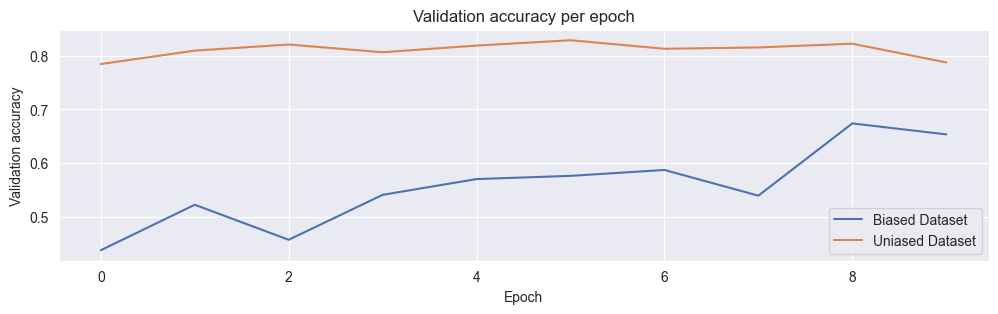

In [14]:
plt.figure(figsize=(12,3))
axs = sns.lineplot(history_biased['accuracy'], label = 'Biased Dataset')
axs = sns.lineplot(history_unbiased['accuracy'], label = 'Uniased Dataset')
_ = axs.set(xlabel='Epoch',
            ylabel='Validation accuracy', 
            title = "Validation accuracy per epoch")